# REDDY

Load modules and initialize objects

In [13]:
import numpy as np
from datetime import datetime, timedelta
from progressbar import ProgressBar, SimpleProgress, ETA
import matplotlib.pyplot as plt
from modules.reddit_api import RedditAPI
from modules.cache_handler import Cache
from credentials import client_id, secret

api   = RedditAPI()
cache = Cache(verbose=False)

api.authenticate(client_id, secret)

# name of the subreddit to analyse
subreddit_name = "datascience"

Download the posts and index them

In [14]:
after = None
count = 0
pbar = ProgressBar(widgets=[SimpleProgress(), ', ', ETA(), "\n"])
iterations = pbar(range(10))

for i in iterations:
    posts, before, after = api.new_posts(subreddit_name, limit=100, after=after, count=count)
    count += len(posts)
    cache.add(posts, overwrite=False)

cache.update_all_indices()

0 of 10, ETA:  --:--:--
1 of 10, ETA:  0:00:09
2 of 10, ETA:  0:00:10
3 of 10, ETA:  0:00:09
4 of 10, ETA:  0:00:07
5 of 10, ETA:  0:00:06
6 of 10, ETA:  0:00:05
7 of 10, ETA:  0:00:03
8 of 10, ETA:  0:00:02
9 of 10, ETA:  0:00:01
10 of 10, Time: 0:00:12



Plot the results

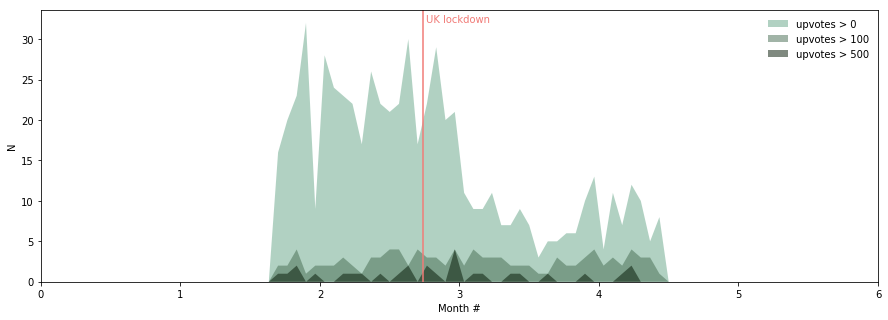

In [30]:
upvote_limits = [0, 100, 500]
colours = ["#64a587", "#446b50", "#011501"]
alphas = [0.5, 0.5, 0.5]

posts = cache.select(subreddit_name, t=None)
posts["created_utc_obj"] = posts.apply(lambda row: datetime.utcfromtimestamp(row["created_utc"]), axis=1)
months_all  = [t.month + t.day/31 - 1 for t in posts["created_utc_obj"]]


# plot
f, ax = plt.subplots(1, 1, figsize=(15, 5))
bins = np.arange(0, 6, 1.0 / 15)

for i, ulim in enumerate(upvote_limits):
    months_some = [t.month + t.day/31 - 1 for t in posts.where(posts["ups"] > ulim).dropna(axis=0, how='any')["created_utc_obj"]]
    y, x = np.histogram(months_some, bins=bins)
    x = 0.5 * (x[1:] + x[:-1])
    ax.fill(x, y, c=colours[i], alpha=alphas[i], lw=0, label=f"upvotes > {ulim}")

lockdown_uk = datetime(2020, 3, 23)
lockdown_uk_month = lockdown_uk.month + lockdown_uk.day/31 - 1
ax.axvline(lockdown_uk_month, c="#f17b77")
ax.text(lockdown_uk_month+0.02, ax.get_ylim()[1]-0.5, "UK lockdown", color="#f17b77", va="top")

ax.set_xlim(0, 6)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Month #")
ax.set_ylabel("N")

plt.legend(frameon=False)
plt.show()
